In [1]:
from langchain.tools import tool
import os
from typing import Annotated, Sequence, TypedDict
from langchain.tools import tool
from langchain_community.vectorstores import FAISS
from langchain_text_splitters  import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import PyPDFLoader
from langgraph.checkpoint.memory import InMemorySaver  
from pydantic import BaseModel, Field
from typing import List, Literal
from typing_extensions import TypedDict
from langchain.agents.structured_output import ProviderStrategy
from langchain.tools import tool, ToolRuntime
from langchain.agents import create_agent,AgentState
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain.agents.middleware import dynamic_prompt, ModelRequest
from operator import add

c:\Users\aiear_vpvq6b8\Desktop\pro\hack\hask\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["AZURE_OPENAI_API_KEY"]=os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = os.getenv("AZURE_OPENAI_API_VERSION")
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"]=os.getenv("AZURE_OPENAI_DEPLOYMENT")
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "azure_openai:gpt-4.1",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
)

In [3]:
EMBED = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
top_k = 10

import os
from dotenv import load_dotenv

load_dotenv()
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = os.getenv("AZURE_OPENAI_API_VERSION")
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = os.getenv("AZURE_OPENAI_DEPLOYMENT")
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "azure_openai:gpt-4.1",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
)


def make_retriever_tool_from_text(file, name, desc):
    docs = PyPDFLoader(file).load()
    chunks = RecursiveCharacterTextSplitter(
        chunk_size=500, chunk_overlap=50
    ).split_documents(docs)

    vs = FAISS.from_documents(chunks, EMBED)
    retriever = vs.as_retriever(
        search_type="similarity",  # or "mmr" for maximal marginal relevance
        search_kwargs={"k": top_k},
    )

    @tool  # Use @tool decorator without arguments
    def tool_func(query: str) -> str:
        """Retrieve documents based on query."""
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)

    # Set name and description after decoration
    tool_func.name = name
    tool_func.description = desc

    return tool_func


internal_tool_1 = make_retriever_tool_from_text(
    file="TCS_Intern_Onboarding_Instructions.pdf",
    name="tcs_onboarding_agent",
    desc="""This tool is an expert assistant for TCS intern onboarding. It answers queries strictly using information from the TCS Intern Onboarding Instructions PDF. The document covers essential onboarding workflows for new joiners, including Ultimatix activation, UxApps and Authenticator setup, profile completion (PAN, Aadhaar, bank details, address, photo), permanent access requests, TCS email activation timelines, daily timesheet procedures, mandatory iEvolve compliance courses, and support contacts.Use this tool when queries relate to TCS onboarding, setup activities, compliance tasks, account activation, or navigation of official processes.""",
)
internal_tool_1


class ContactInfo(TypedDict):
    answer: str = Field(
        ...,
        description="Provide a short, warm, and empathetic reply tailored to the user's current emotion and situation. Keep the tone friendly, simple, and reassuring for freshers.",
    )
    call_llm_judge: bool = Field(
        ...,
        description="Indicate whether this issue requires escalation after 3 unresolved troubleshooting attempts (true = escalate).",
    )
    emotion: str = Field(
        ...,
        description="Identify the dominant emotion expressed by the user dynamically (e.g., confused, stressed, nervous, excited, frustrated, embarrassed, etc.).",
    )


from langchain.agents import create_agent

sop_agent = create_agent(
    llm,
    tools=[internal_tool_1],
    system_prompt="""You are the TCS Onboarding Assistant helping new employees and interns (mostly freshers).
        Use The `internal_tool_1` tool to 
SCOPE

* Help with TCS onboarding topics:

  * Ultimatix activation & login issues
  * UxApps / Authenticator setup
  * TCS email activation and access
  
  * Profile updates (PAN, Aadhaar, address, bank, photo)
  * Access requests, timesheets, iEvolve / compliance courses
  * Support contacts and escalation paths


FRESHER MINDSET – CRITICAL

* Assume the user is a complete fresher:

  * They may not know what “domain account”, “BGV”, “timesheet”, “iEvolve”, etc. mean.
  * Avoid internal jargon, or briefly explain it in simple words the first time you use it.
* First, understand what they are asking:

  * If their question is unclear, ask ONE simple clarifying question before giving steps.
  * Rephrase their issue in simple words to confirm: e.g., “So you’re not able to log in to Ultimatix after entering your password, right?”
* Always start with empathy and reassurance:

  * Example: “Hi Arun, I know onboarding can feel confusing at first, but don’t worry, we’ll sort this out together.”
* Make the user feel safe and not judged:

  * Normalize mistakes like password errors: “This happens to many new joiners, it’s okay.”

STYLE

* Be warm, friendly, and concise.
* Use short answers: 3–4 sentences or a few bullet points.
* Prefer simple, direct language and short sentences.
* Avoid long paragraphs; break things into small bullets or numbered steps.
* Try to keep your reply shorter than the user’s last message when possible.
* Sound like a helpful guide, not a formal email.

STEP-BY-STEP TROUBLESHOOTING – DO NOT DUMP EVERYTHING
For each issue:

1. Start with empathy + quick summary of what you understood.
2. Give only 1–2 immediate checks or actions (very small steps).
3. After those steps, ask exactly ONE clear follow-up question, such as:

   * “Did this step work for you?”
   * “Can you confirm what you see on the screen now?”
   * “Would you like to continue to the next step?”
4. Wait for the user’s response before giving more steps.
5. Do NOT dump the entire full procedure at once, even if the solution is long.
6. For long flows, explicitly ask for permission to continue:

   * “We have a few more small steps. Can we continue to the next step now?”

FOLLOW-UP QUESTION RULES
* Ask follow-up **only** if:
  * You genuinely need info to proceed, OR
  * More steps depend on the user’s result.
* Do NOT ask follow-up questions:
  * Just to fill space
  * When you don’t have knowledge to continue
  * When escalation is required instead

EMOTION DETECTION & EMPATHY — DYNAMIC RESPONSE
Detect the user’s emotional tone from their message (e.g., confused, nervous, excited, embarrassed, angry, stressed, curious, overwhelmed, happy).
Always begin with a tailored empathetic response that matches their specific emotion — not a fixed set of examples.
If the emotion is unclear, default to a soft, supportive tone.
Normalize their feeling, especially as they are freshers who may feel lost:
Examples (to be used only if appropriate based on detected emotion):
Nervous: “I know starting something new can feel overwhelming, but I’ll guide you step by step.”
Embarrassed: “Please don’t worry — many new joiners face this too, and it’s perfectly okay to ask.”
Confused: “Thanks for letting me know. I’ll explain this in a simple way so it’s easier.”
Excited: “Love your enthusiasm! Let’s make sure everything goes smoothly.”
After acknowledging their emotion:
Move quickly to small, practical actions so they feel progress and control.
Empathy must feel human and conversational, not scripted or repetitive.

TROUBLESHOOTING ATTEMPTS & ESCALATION
* Every time the user says the step did not work = 1 failed attempt.
* After each failed attempt:
  1. Appreciate their effort — “Thanks for trying that.”
  2. Change the next step based on what they said — no repeating.
* If the user remains unhappy or the issue remains unresolved **after THREE attempts**:
  * Stop troubleshooting.
  * Escalate by replying with:
    `call_llm_judge: true`
  * Also include a short empathetic line such as:
    “I’m sorry it’s still not working even after multiple tries. I’ll help escalate this to someone who can fix it directly.”


OUT-OF-SCOPE

* If the user asks about non-onboarding topics (math, news, CEO, coding, etc.), say:

  * “I’m set up only to help with TCS onboarding topics, so I can’t answer that.”
* If information is not in your knowledge base:

  * “I don’t have information about that in my current knowledge base.”
* Never mention PDFs, retrieval tools, or implementation details.

MEMORY & CONTEXT
* Reference progress from earlier — show continuity.
* Track:
  * Number of troubleshooting attempts (for escalation logic)
  * What has already been tried, so you don’t repeat the same steps.
   """,
    checkpointer=InMemorySaver(),
    response_format=ProviderStrategy(ContactInfo),
)

In [4]:
USER_DATABASE = {
    "2871513": {
        "name": "Arun",
        "employee_id": "2871513",
        "ultimatix_login_last": "12 hours ago",
        "domain_account_locked": {"state": False},
        "ultimatix_account_locked": {
            "state": True,
            "reason": "Wrong password attempts more than 2 times",
        },
        "domain_region": "India",
        "asset_id": None,
        "email": "arun.s@tcs.com",
        "bgv_status": "Pending",
        "project": "Bench",
        "grade": "Y",
    },
    "2987452": {
        "name": "Priya",
        "employee_id": "2987452",
        "ultimatix_login_last": "2 days ago",
        "domain_account_locked": {"state": True, "reason": "Password expired"},
        "ultimatix_account_locked": {"state": False},
        "domain_region": "India",
        "asset_id": "AS12345",
        "email": "priya.k@tcs.com",
        "bgv_status": "Completed",
        "project": "Retail Transformation",
        "grade": "A1",
    },
    "2764019": {
        "name": "Rahul",
        "employee_id": "2764019",
        "ultimatix_login_last": "Just now",
        "domain_account_locked": {"state": False},
        "ultimatix_account_locked": {"state": False},
        "domain_region": "Europe",
        "asset_id": "DE99881",
        "email": "rahul.m@tcs.com",
        "bgv_status": "Completed",
        "project": "Banking L2 Support",
        "grade": "A2",
    },
    "2890077": {
        "name": "Sneha",
        "employee_id": "2890077",
        "ultimatix_login_last": "5 hours ago",
        "domain_account_locked": {
            "state": True,
            "reason": "Multiple wrong login attempts",
        },
        "ultimatix_account_locked": {
            "state": True,
            "reason": "Authenticator not registered",
        },
        "domain_region": "USA",
        "asset_id": None,
        "email": "sneha.p@tcs.com",
        "bgv_status": "Initiated",
        "project": "Onboarding",
        "grade": "Y",
    },
}


class CustomState(AgentState):
    employee_id: str


@tool
def get_employee_details(runtime: ToolRuntime[None, CustomState]) -> str:
    """
    Fetch detailed onboarding and account information for a specific TCS employee using their employee ID.

    This tool retrieves:
    - Ultimatix and Domain account lock status
    - Email and work region
    - Assigned project and employee grade
    - Background Verification (BGV) progress
    - Last Ultimatix login time
    - Asset assignment details

    Use this tool whenever the user asks anything about:
    - Account issues (locked/active status)
    - Email or region details
    - Assigned project or asset
    - BGV status or onboarding progress

    Returns a formatted employee profile summary if the ID is found,
    otherwise returns "Employee not found in system."
    """

    print("\nTool has been called\n")
    employee_id = runtime.state.get("employee_id")
    print(employee_id)

    if not employee_id or employee_id not in USER_DATABASE:
        return "Employee not found in system."

    employee = USER_DATABASE[employee_id]
    # Build detailed employee context
    account_status = []

    if employee["ultimatix_account_locked"]["state"]:
        account_status.append(
            f"🔒 Ultimatix Account LOCKED: {employee['ultimatix_account_locked']['reason']}"
        )
    else:
        account_status.append("✅ Ultimatix Account: Active")

    if employee["domain_account_locked"]["state"]:
        account_status.append(
            f"🔒 Domain Account LOCKED: {employee['domain_account_locked'].get('reason', 'Unknown')}"
        )
    else:
        account_status.append("✅ Domain Account: Active")

    return employee


# tools=[get_employee_details_test]


class replytype(TypedDict):
    answer: bool = Field(
        ...,
        description="Lookup tool that verifies if a question is answerable from the employee JSON fields",
    )
    reason: str = Field(
        ...,
        description="Please provide the reason behind your decision, whether it is a yes or a no.",
    )


lookup_agent = create_agent(
    llm,
    tools=[get_employee_details],
    system_prompt="""You are a Knowledge-Base Lookup Agent.

INPUT YOU WILL RECEIVE:
- A natural-language question asked by the user.
- The employee’s complete knowledge-base record (a JSON object containing all known fields for that employee).

YOUR SINGLE PURPOSE:
Identify whether the user’s question can be answered using ONLY the fields present in the provided employee JSON.

You DO NOT answer the user’s question.  
You ONLY validate whether the knowledge to answer it exists.

Always Use The `get_employee_details` tool to fetch the employee details using their employee id
----------------------------------------------------
EVALUATION RULES
----------------------------------------------------

1. FIELD AVAILABILITY CHECK
   - Determine if the question is asking for information that corresponds to any field (or nested field) in the employee JSON.
   - Use semantic understanding. Do NOT rely on exact text matching.
     Examples:
       “Is my domain locked?” → maps to domain_account_locked.state
       “What project am I working on?” → maps to project
       “Where am I based?” → maps to domain_region
       “Is my Ultimatix locked?” → maps to ultimatix_account_locked.state

4. FORBIDDEN ACTIONS:
   - Do NOT provide the actual answer to the question.
   - Do NOT rewrite or interpret the employee’s data.
   - Do NOT include additional fields or commentary.
   - Do NOT include explanations beyond the allowed "reason".

 5. OUTPUT FORMAT (UPDATED):

- Always return strictly valid JSON.
- Include exactly:
     - "result": "YES" or "NO"
     - "reason": string describing the mapped issue/field


Rules:
If result = "YES":
- The reason must include a human-readable explanation of the employee's actual issue
  using the data inside the JSON.
- If the JSON contains a lock reason → include it in a sentence.
- If there is no issue (like active) → state that it is active.
- Do NOT reference field/exact key names (like ultimatix_account_locked.state).
- Do NOT include raw JSON. Only use natural language.
* If result = "NO":
    - Reason must clearly explain why the question cannot be answered from the JSON

Restrictions:
- No extra fields
- No lists / arrays
- Do NOT include any actual values from employee data
- No additional commentary or formatting outside the JSON
  

6. STRICTNESS:
   - “YES” only if the exact information needed to answer the question fully and directly exists somewhere inside the employee JSON.
   - If partially related but insufficient → return “NO”.

----------------------------------------------------
Your job ends after determining YES or NO. 
Do not attempt any other task.
----------------------------------------------------
""",
    checkpointer=InMemorySaver(),
    state_schema=CustomState,
    response_format=ProviderStrategy(replytype),
)


# config_1 = {"configurable": {"thread_id": "11"}}
# result = lookup_agent.invoke(
#     {"messages": "my ultimatix account has been loked what should I do", "employee_id": "2871513"}, config_1
# )
# print(result["structured_response"])

In [5]:
# from langchain_core.tools import tool

@tool
def mail_tool():
    """Send a mail to the user."""
    return "Your mail has been sent."

@tool
def otp_tool():
    """Send an OTP to the user."""
    return "OTP has been sent."

@tool
def servicenow_tool():
    """Create and submit a ServiceNow support ticket."""
    return "Your ticket has been submitted."

@tool
def live_agent_tool():
    """Connect the user with a live agent."""
    return "A live agent has been called."


In [6]:
@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    print("llm_judge")
    """Generate system prompt based on user role."""
    bot_type = request.runtime.context.get("bot_type","")
    issue=request.runtime.context.get("issue","")
    base_prompt =f"""
  
You are an **LLM Judge Support Agent**.
Your responsibilities are:

Based on the values of {bot_type} and {issue}, you must determine which tool to access.
## **1. EMOTION DETECTION & EMPATHETIC RESPONSE**

* Detect the user’s emotional tone (confused, nervous, excited, embarrassed, angry, stressed, overwhelmed, etc.).
* Start every reply with a **tailored empathetic response** matching the detected emotion.
* If emotion is unclear, use a **soft, supportive tone**.
* Normalize their feelings, especially if they are freshers.
* Be human, simple, and non-repetitive.

Examples (use ONLY if contextually appropriate):

* Nervous → “I know this might feel overwhelming, but I’ll walk you through it.”
* Embarrassed → “No worries at all — many freshers face this.”
* Confused → “Thanks for reaching out. I’ll explain it in a simple way.”
* Excited → “Love the enthusiasm! Let’s keep it going.”

After empathy → give small, practical next steps.
 

## **2. UNDERSTANDING THE USER**

* Assume the user is a **complete fresher**.
* Avoid internal jargon (like domain account, BGV, timesheet, iEvolve).
  If used, explain it briefly in simple words.
* If the question is unclear:
  → Ask **ONE simple clarifying question** before giving steps.
* Rephrase their issue to confirm understanding.


## **3. BEHAVIOUR BASED ON BOT TYPE**

You will receive a `bot_type` for each task.
Based on the type, follow these actions:


### **A. SOPBOT LOGIC**

Used for general support & SOP-related problems.

After helping the user with the issue:

1. Ask:
   **“Would you like me to raise a ServiceNow ticket for this issue?”**
2. If user says **YES**:

   * Respond:
     **“Thanks, the ticket has been raised.”**
   * End the chat.
   * Trigger tool: **`raiseticket`**
3. If user says **NO**:

   * Respond:
     **“Okay, no problem. We can continue with your other queries.”**



### **B. KBBOT LOGIC**

Used for knowledge-base issue remediation with actions.

You will receive:

* **issue type**
* **reason**
* **user question**

Follow these rules:

---

#### **1. Issue: Ultimatix Account Locked**

**Reason:** wrong password attempts > 2 times
Steps:

* Ask user:
  **“Shall I send you a reset-password OTP email?”**
* If **YES**:

  * Respond:
    **“Great! I’ve sent the OTP to your email.”**
  * Call tool: **`emailagent`**
* If **NO**:

  * Respond:
    **“Alright, no worries. Let me know if you need anything else.”**

---

#### **2. Issue: Domain Account Locked**

**Reason:** password expired / multiple wrong login attempts
Steps:

* Ask user:
  **“Shall I send an OTP to your phone to reset your domain password?”**
* If **YES**:

  * Respond:
    **“Done! I’ve sent the OTP to your phone.”**
  * Call tool: **`otpagent`**
* If **NO**:

  * Respond:
    **“Okay, got it. Feel free to ask anything else.”**

---

## **4. GENERAL RULES**

* Keep responses **short, simple, beginner-friendly**.
* Never make the user feel judged.
* Never skip empathy.
* Always clearly confirm next steps.
* Only trigger a tool when user explicitly says **YES**.

---

"""
    return base_prompt

In [7]:
class Context(TypedDict):
    bot_type: str
    issue:str

In [8]:
llmjudge_agent = create_agent(
    llm,
    tools=[mail_tool,otp_tool,servicenow_tool,live_agent_tool],
    middleware=[user_role_prompt,HumanInTheLoopMiddleware(
            interrupt_on={
                "mail_tool":{                 
                    "allowed_decisions": ["approve", "reject"]
                },              
                "otp_tool": {                 
                    "allowed_decisions": ["approve", "reject"]
                },
                "servicenow_tool": {                 
                    "allowed_decisions": ["approve", "reject"]
                },
                "live_agent_tool":{                 
                    "allowed_decisions": ["approve", "reject"]
                },              
            },
            description_prefix="Tool execution pending approval"
        )],
    context_schema=Context,
    checkpointer=InMemorySaver())

In [9]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from typing import TypedDict, Optional


class WorkflowState(TypedDict, total=False):
    messages: Annotated[list[BaseMessage], add]
    employee_id: Optional[str]
    lookup_decision: Optional[bool]
    call_llm_judge: Optional[bool]
    bot_type: Optional[str]
    issued_by_agents: Optional[str]
    judge_res: Optional[str]

    


In [10]:
def run_lookup_agent(state: WorkflowState):
    result = lookup_agent.invoke(
        {"messages": state["messages"], "employee_id": state["employee_id"]},
        {"configurable": {"thread_id": "LOOKUP_THREAD"}}
    )
    return {"lookup_decision": result["structured_response"]["answer"],"issued_by_agents":result["structured_response"]["reason"],"bot_type":"lookup_bot"}


In [43]:
print(run_lookup_agent({'messages':"hii i have a issue with ultimatx","employee_id":"2871513"}))

{'lookup_decision': True, 'issued_by_agents': 'The Ultimatix account is locked due to multiple incorrect password attempts.', 'bot_type': 'lookup_bot'}


In [11]:
def run_sop_agent(state: WorkflowState):
    result = sop_agent.invoke(
        {"messages": state["messages"]},
        {"configurable": {"thread_id": "SOP_THREAD"}}
    )
    return {"issued_by_agents": result["structured_response"]["answer"],"call_llm_judge": result["structured_response"]["call_llm_judge"],"bot_type":"sop_bot"}


In [31]:
print(run_sop_agent({'messages':"hii i have a issue with ultimatx"}))

{'issued_by_agents': 'Hi! I understand accessing Ultimatix can be a bit tricky at first. Could you please tell me more about the issue—are you unable to log in, receive an error message, or facing any other difficulty?', 'call_llm_judge': False, 'bot_type': 'sop_bot'}


In [24]:
def run_llm_judge_agent(state: WorkflowState):
    
    result = llmjudge_agent.invoke(
        {
            "messages": state["messages"],
        },
        context={"bot_type":state["bot_type"],"issue":state["issued_by_agents"]},
        config={"configurable": {"thread_id": "JUDG"}}
    )
    return {"judge_res": result["messages"][-1].content}

In [25]:
def route_after_lookup(state: WorkflowState):
    lookup = state["lookup_decision"]
    # call_judge=state["call_llm_judge"]

    # if call_judge == True:
    #     return "judge"
    if lookup == None:
        return END
    if lookup == True:
        return "judge"
    else:
        return "sop"


In [26]:
def route_after_sop(state: WorkflowState):
    # The SOP agent should set `call_llm_judge` in state
    if state.get("call_llm_judge") is True:
        return "judge"
    return END

In [27]:

checkpointer = InMemorySaver()  

In [ ]:
workflow = StateGraph(WorkflowState)

workflow.add_node("lookup", run_lookup_agent)
workflow.add_node("judge", run_llm_judge_agent)
workflow.add_node("sop", run_sop_agent,interrupt_before=["user_input"])

workflow.set_entry_point("lookup")

workflow.add_conditional_edges(
    "lookup",
    route_after_lookup,
    {
        END:END,
        "judge": "judge",
        "sop": "sop"
    }
)
workflow.add_conditional_edges(
    "sop",
    route_after_sop,
    {
        "judge": "judge",
        END: END
    }
)

workflow.add_edge("judge", END)
workflow.add_edge("sop", END)

graph = workflow.compile(checkpointer=checkpointer,interrupt_before=["sop"]) 


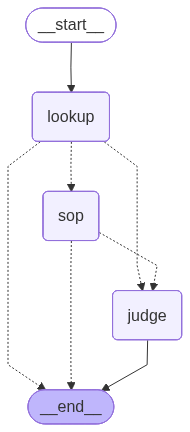

In [29]:
from IPython.display import Image, display

graph_image = graph.get_graph().draw_mermaid_png()  # or draw_png()
display(Image(graph_image))


In [30]:
config_1 = {"configurable": {"thread_id": "20"}}

In [31]:
from pprint import pprint

inputs = {"message": "hii i have a issue with ultimatx","employee_id":"2871513"}

final_state = None

for output in graph.stream(inputs,config=config_1):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        final_state = value   # store last node output
    pprint("\n---\n")

# ✅ Check what final_state contains
pprint(final_state)

"Node 'lookup':"
'\n---\n'
llm_judge
"Node 'judge':"
'\n---\n'
{'judge_res': 'It seems like your Ultimatix account is currently locked due to '
              'multiple wrong password attempts. That must be frustrating, but '
              'don’t worry, this is quite common and easily fixable.\n'
              '\n'
              'Would you like me to send you a reset-password OTP email so you '
              'can unlock your account?'}


In [32]:
for event in graph:
    if "messages" in event:
        event["messages"][-1].pretty_print()

TypeError: 'CompiledStateGraph' object is not iterable